## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants, e.g., TensorFlow. This very excellent framework will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

**Acknowledgement: This exercise is adapted from [Stanford CS231n](http://cs231n.stanford.edu/index.html).**

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from libs.tf_layers import *
from libs.vis_utils import *

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load Datasets


In [2]:
from libs.data_utils import load_CIFAR10

NUM_CLASSES = 10
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'libs/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints (mini-batch size)
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss (multi-class SVM) function, and the SGD optimizer being used. 

Make sure you understand **why the parameters of the Linear layer are 5408 and 10**. You can refer to the material from [CS231n webpages](http://cs231n.github.io/convolutional-networks/).

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define SGD optimizer
optimizer = tf.train.GradientDescentOptimizer(2e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm. Note that there are few other implementations of batch normalization layers, e.g., [link 1](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm), [link 2](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization).

### Training the model on one epoch
Define the function to train a model as following.

In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    train_indicies = np.arange(Xd.shape[0])
    
    training_now = (training is not None)
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, correct_prediction, accuracy]
    if training_now:
        variables[-1] = training

    # counter 
    iter_cnt = 0
    # keep track of losses
    losses = []
    for e in range(epochs):
        # shuffle indicies
        np.random.shuffle(train_indicies)
        # keep track of accuracy
        correct = 0
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            corr = np.array(corr).astype(np.float32)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        
    if plot_losses:
        plt.plot(losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()
            
    return total_loss,total_correct,losses


While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu). Generally, if your machine has GPU available (with all required drivers) and you install Tensorflow GPU version, Tensorflow will automatically select GPU as the primary device. Otherwise, CPU will be selected as the primary device.

You should see a validation loss of around 1 and an accuracy of 0.2 below

Training
Iteration 0: with minibatch training loss = 10.8 and accuracy of 0.031
Iteration 100: with minibatch training loss = 2.32 and accuracy of 0.094
Iteration 200: with minibatch training loss = 1.82 and accuracy of 0.14
Iteration 300: with minibatch training loss = 1.38 and accuracy of 0.2
Iteration 400: with minibatch training loss = 1.48 and accuracy of 0.17
Iteration 500: with minibatch training loss = 1.2 and accuracy of 0.23
Iteration 600: with minibatch training loss = 1.14 and accuracy of 0.16
Iteration 700: with minibatch training loss = 1.09 and accuracy of 0.27
Epoch 1, Overall loss = 1.52 and accuracy of 0.203


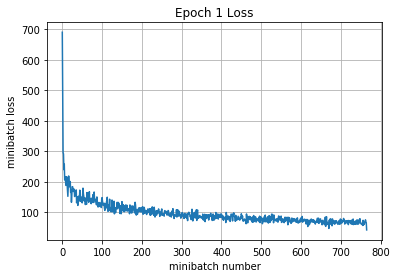

Validation
Epoch 1, Overall loss = 1.02 and accuracy of 0.231


In [5]:
with tf.Session() as sess:
    #with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,plot_losses=True)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)


## Graph visualization

In [6]:
show_graph(tf.get_default_graph().as_graph_def())

### Tensorboard for Visualization

Tensorflow provides a very useful tool: Tensorboard. This is very helpful to visualize the training loss, accuray, filters,...

Here is a good video about Tensorboard: https://www.youtube.com/watch?v=eBbEDRsCmv4

In [7]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [8]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])
    variable_summaries(Wconv1)
    variable_summaries(W1)

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define SGD optimizer
optimizer = tf.train.GradientDescentOptimizer(2e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

In [9]:
def run_model_with_tensorboard(session, predict, loss_value, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, tensorboard_writer=None):
    
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    train_indicies = np.arange(Xd.shape[0])
    
    training_now = (training is not None)
    
    tf.summary.scalar("cost", loss_value)
    tf.summary.scalar("accuracy", accuracy)
    summary_op = tf.summary.merge_all()

    # counter 
    iter_cnt = 0
    # keep track of losses
    losses = []
    for e in range(epochs):
        # shuffle indicies
        np.random.shuffle(train_indicies)
        # keep track of accuracy
        correct = 0
        # make sure we iterate over the dataset once
        batch_count = int(math.ceil(Xd.shape[0]/batch_size))
        for i in range(batch_count):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            if training_now:
                _, summary = session.run([training, summary_op],feed_dict=feed_dict)
                # write log
                tensorboard_writer.add_summary(summary, e * batch_count + i)
            else:
                summary = session.run(summary_op, feed_dict=feed_dict)
    return

In [10]:
# define SGD optimizer
print('SGD optimizer')
optimizer = tf.train.AdamOptimizer(1e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('logs/train', graph=tf.get_default_graph())
    #with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model_with_tensorboard(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,
                               tensorboard_writer=train_writer)

# tensorboard --logdir=logs/train
print("Run the command line:\n" \
          "--> tensorboard --logdir=logs/train " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

# NOTE: In Window, you may not able to run the Tensorboard.

SGD optimizer
Training
Run the command line:
--> tensorboard --logdir=logs/train 
Then open http://0.0.0.0:6006/ into your web browser


# Update rules

You are going to see [ADAM optimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) being used. Now, we will compare the training loss curves of a model with SGD and ADAM optimizers.

You can try other optimizers, e.g., [SGD+Momentum](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer), [RMSprop](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer), [Adagrad](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer), [Adadelta](https://www.tensorflow.org/api_docs/python/tf/train/AdadeltaOptimizer).

In [ ]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define SGD optimizer
print('SGD optimizer')
optimizer = tf.train.GradientDescentOptimizer(1e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    #with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    _,_, sgd_losses = run_model(sess,y_out_deep,mean_loss,X_train,y_train,1,64,100,train_step,False)
    print('Validation')
    run_model(sess,y_out_deep,mean_loss,X_val,y_val,1,64)

print("==========================================================\n")
# define Adam optimizer
print('ADAM optimizer')
optimizer = tf.train.AdamOptimizer(1e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
#     with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    _,_, adam_losses = run_model(sess,y_out_deep,mean_loss,X_train,y_train,1,64,100,train_step,False)
    print('Validation')
    run_model(sess,y_out_deep,mean_loss,X_val,y_val,1,64)
    
plt.plot(sgd_losses, label='SGD')
plt.plot(adam_losses, label='ADAM')
# plt.plot(adam_losses_batchnorm, label='ADAM+BatchNorm')
# plt.ylim( (0, 100) ) 
plt.grid(True)
plt.legend()
plt.title('Epoch 1 Loss')
plt.xlabel('minibatch number')
plt.ylabel('minibatch loss')
plt.show()

# Go Deeper

In the previous exercises, you are required to implement different functions, e.g., affine, relu, conv2d, ... which serve as basic module to build a Deep Neuron Network. Similarly, we provide the basic modules for Tensorflow in `libs/tf_layers.py`.

**NOTE:** In this exercise, you are welcome to change the block functions in `libs/tf_layers.py` to fit your needs the best.

In [ ]:
# define a deep network
def deep_model(X, y, batchnorm=False, name=None):
    output = Conv2D(X, 3, 7, 8, name=name+'_conv1')
    output = tf.nn.relu(output, name=name+'_relu1')
    if batchnorm:
        output = BatchNormalization(output, True, name=name+'_BN1')
    output = Conv2D(output, 8, 7, 8, name=name+'_conv2')
    output = tf.nn.relu(output, name=name+'_relu2')
    if batchnorm:
        output = BatchNormalization(output, True, name=name+'_BN2')
    output = MaxPooling2D(output, name=name+'_maxpool1')
    output = Conv2D(output, 8, 7, 16, name=name+'_conv3')
    output = tf.nn.relu(output, name=name+'_relu3')
    if batchnorm:
        output = BatchNormalization(output, True, name=name+'_BN3')
    output = Conv2D(output, 16, 7, 16, name=name+'_conv4')
    
    # Here is another way of defining a name for a layer
    with tf.variable_scope(name+'_relu4'):
#         output = tf.nn.relu(output, name=name+'_relu4')
        output = tf.nn.relu(output)
    if batchnorm:
        output = BatchNormalization(output, True, name=name+'_BN4')
    output = MaxPooling2D(output, name=name+'_maxpool2')
    output = tf.reshape(output, [-1, 16*8*8], name=name+'_flatten')
    output = FullyConnected(output, 16*8*8, 100, name=name+'_fc1')
    output = tf.nn.relu(output, name=name+'_relu5')
    output = FullyConnected(output, 100, 100, name=name+'_fc2')
    output = tf.nn.relu(output, name=name+'_relu6')
    output = FullyConnected(output, 100, 10, name=name+'_fc3')
    return output

We will now see the benefit of using **batch normalization** layer.

In [ ]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out_deep2 = deep_model(X,y, True, name='deep2')
# define our loss
total_loss_deep2 = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out_deep2)
mean_loss = tf.reduce_mean(total_loss_deep2)

print("==========================================================\n")
# define Adam optimizer
print('ADAM optimizer')
optimizer = tf.train.AdamOptimizer(1e-4) # select optimizer and set learning rate

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
#     with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    _,_, adam_losses_batchnorm = run_model(sess,y_out_deep2,mean_loss,X_train,y_train,1,64,100,train_step,False)
    print('Validation')
    run_model(sess,y_out_deep2,mean_loss,X_val,y_val,1,64)
    
plt.plot(sgd_losses, label='SGD')
plt.plot(adam_losses, label='ADAM')
plt.plot(adam_losses_batchnorm, label='ADAM+BatchNorm')
plt.ylim( (0, 100) ) 
plt.grid(True)
plt.legend()
plt.title('Epoch 1 Loss')
plt.xlabel('minibatch number')
plt.ylabel('minibatch loss')
plt.show()

### More epochs
Train the model with more epochs to see how good performance it can achieve.

**NOTE:** If you run this on a CPU, it will take some time.

In [ ]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out_deep2 = deep_model(X,y, True, name='deep2')
# define our loss
total_loss_deep2 = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out_deep2)
mean_loss = tf.reduce_mean(total_loss_deep2)

print("==========================================================")
# define Adam optimizer
print('ADAM optimizer')
optimizer = tf.train.AdamOptimizer(1e-4) # select optimizer and set learning rate
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
#     with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    _,_, adam_losses_batchnorm = run_model(sess,y_out_deep2,mean_loss,X_train,y_train,5,64,100,train_step,True)
    print('Validation')
    run_model(sess,y_out_deep2,mean_loss,X_val,y_val,1,64)

##  Train a _GREAT_ model on CIFAR-10!

### Things you should try:
- **Filter size**: Above we used 7x7; bigger filters captures more information but smaller filters may be more computationally efficient.
- **Number of filters**: Above we used 32 (or less) filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros).

**NOTE:**
* In this exercise, you are welcome to change the block functions in `libs/tf_layers.py` to fit your needs the best.
* Softmax cross-entropy loss: [tf.losses.softmax_cross_entropy](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/losses/softmax_cross_entropy)
* SVM loss: [tf.losses.hinge_loss](https://www.tensorflow.org/api_docs/python/tf/losses/hinge_loss)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should **see improvement within a few hundred iterations.**
- Remember the **coarse-to-fine** approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should **use the validation set for hyperparameter search**, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.



### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 60% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

In [ ]:
# Feel free to play with this cell
# You can implement the model in a seperate python file.

def my_model(X,y,is_training):
    pass

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

pass

In [ ]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [ ]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 60% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Test Set - DO THIS ONLY ONCE
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [ ]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

## Extra Credit Description
Briefly describe what you did here.

In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_